# Reinforcement Learning: Min Distance RL with CARLA CL (Larger Model) 13/01/22

At the recommednation of one of the authors of the paper I will try to adapt the following [tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) to work acheive the same results as in the paper.

Notes: Pygame only runs on python 3.7, pytorch must be install direclty into the env

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import carla
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

from torch.utils.tensorboard import SummaryWriter

import gym
import gym_carla

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# parameters for the gym_carla environment
params = {
    'number_of_vehicles': 0,
    'number_of_walkers': 0,
    'display_size': 256,  # screen size of bird-eye render
    'max_past_step': 1,  # the number of past steps to draw
    'dt': 0.1,  # time interval between two frames
    'discrete': True,  # whether to use discrete control space
    'discrete_acc': [2.0],  # discrete value of accelerations
    'discrete_steer': [-0.3, 0.0, 0.3],  # discrete value of steering angles
    'continuous_accel_range': [-3.0, 3.0],  # continuous acceleration range
    'continuous_steer_range': [-0.3, 0.3],  # continuous steering angle range
    'ego_vehicle_filter': 'vehicle.lincoln*',  # filter for defining ego vehicle
    'port': 3000,  # connection port
    'town': 'Town04',  # which town to simulate
    'task_mode': 'random',  # mode of the task, [random, roundabout (only for Town03)]
    'max_time_episode': 500,  # maximum timesteps per episode
    'max_waypt': 12,  # maximum number of waypoints
    'obs_range': 32,  # observation range (meter)
    'lidar_bin': 0.125,  # bin size of lidar sensor (meter)
    'd_behind': 12,  # distance behind the ego vehicle (meter)
    'out_lane_thres': 2.5,  # threshold for out of lane
    'desired_speed': 3,  # desired speed (m/s)
    'max_ego_spawn_times': 20,  # maximum times to spawn ego vehicle
    'display_route': True,  # whether to render the desired route
    'pixor_size': 64,  # size of the pixor labels
    'pixor': False,  # whether to output PIXOR observation
    'routes':{'Town04':{'H':[264,234]}},
    'weather':'ClearNoon',
    'obs_size':128
}

#{'Town04':{'E':[0,301,334,120,75,51],
#                                'M':[191,131,197,210,371,348,141,320],
#                                'H':[251,161,264,234,167,182]
#                                }
#                    },

# Set gym-carla environment
env = gym.make('carla-v0', params=params)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
connecting to Carla server...
Carla server connected!
WeatherParameters(cloudiness=5.000000, cloudiness=5.000000, precipitation=0.000000, precipitation_deposits=0.000000, wind_intensity=10.000000, sun_azimuth_angle=-1.000000, sun_altitude_angle=45.000000, fog_density=2.000000, fog_distance=0.750000, fog_falloff=0.100000, wetness=0.000000, scattering_intensity=1.000000, mie_scattering_scale=0.030000, rayleigh_scattering_scale=0.033100)


In [3]:

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    
    def __len__(self):
        return len(self.memory)


In [4]:
class PerceptionNet(nn.Module):

    def __init__(self):
        super(PerceptionNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(512, 64, kernel_size=4, stride=1)
        
        self.conv7 = torch.nn.ConvTranspose2d(64,512, kernel_size =4, stride=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.conv8 = torch.nn.ConvTranspose2d(512,256, kernel_size =4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.conv9 = torch.nn.ConvTranspose2d(256,128, kernel_size =4, stride=2, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.conv10 = torch.nn.ConvTranspose2d(128,64, kernel_size =4, stride=2, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv11 = torch.nn.ConvTranspose2d(64,32, kernel_size =4, stride=2, padding=1)
        self.bn10 = nn.BatchNorm2d(32)
        
        self.conv12 = torch.nn.ConvTranspose2d(32,23, kernel_size =4, stride=2,padding=1)
        
            
    def encode(self, x):
        x = F.leaky_relu(self.conv1(x),negative_slope=0.02)
        x = F.leaky_relu(self.bn2(self.conv2(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn3(self.conv3(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn4(self.conv4(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn5(self.conv5(x)),negative_slope=0.02)
        return self.conv6(x)
    
    def decode(self, x):
        x = F.leaky_relu(self.bn6(self.conv7(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn7(self.conv8(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn8(self.conv9(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn9(self.conv10(x)),negative_slope=0.02)
        x = F.leaky_relu(self.bn10(self.conv11(x)),negative_slope=0.02)
        return F.log_softmax(self.conv12(x),dim=1)
    
    def forward(self, x):
        x = x.to(device, dtype=torch.float32)
        latent = self.encode(x)
        out = self.decode(latent)
        return out, latent

In [5]:
class Full_DQN(nn.Module):

    def __init__(self, outputs,input_size):
        super(Full_DQN, self).__init__()
        
        self.lin1 = nn.Linear(input_size+9,100)
        self.lin2 = nn.Linear(100,50)
        self.lin3 = nn.Linear(50,25)
        self.lin4 = nn.Linear(25,15)
        self.lin5 = nn.Linear(15,8)
        self.lin6 = nn.Linear(8,3)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = F.relu(self.lin5(x))
        x = self.lin6(x)
        
        return x.view(x.size(0), -1)

In [6]:
def initalize_weights(layer):
    if isinstance(layer, torch.nn.Linear) or isinstance(layer,torch.nn.Linear):
        nn.init.kaiming_uniform_(layer.weight.data,nonlinearity='relu')

In [7]:
BATCH_SIZE = 512
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TARGET_UPDATE = 256

writer = SummaryWriter()

n_actions = env.action_space.n

policy_net = Full_DQN(n_actions,64).to(device)
#policy_net.load_state_dict(torch.load('./model_params_CL/Full_model_4.final'))
policy_net.apply(initalize_weights)
policy_net.eval()

target_net = Full_DQN(n_actions,64).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

model = PerceptionNet()
model.to(device)
model.load_state_dict(torch.load('./AE_params/model_3.best'))
model.eval()
#don't want to update AE model 
for param in model.parameters():
    param.requires_grad = False

# Model <= 7
optimizer = optim.RMSprop(policy_net.parameters(),lr=0.005)

#Model 8 & from 2022 
#optimizer = optim.Adam(policy_net.parameters(),lr=0.005)


memory = ReplayMemory(7500)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            #arg max select the idex of the largest value and view changes shape from (1,) to (1,1)
            #try test net
            return policy_net(state.float()).argmax().view(1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []

In [8]:
def optimize_model(input_size):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    #reshape state_batch for nn
  
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    # selects column of output that was selceted 
    state_action_values = policy_net(torch.reshape(state_batch,(BATCH_SIZE,1,input_size)).float()).gather(1,action_batch)
    
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(torch.reshape(non_final_next_states,
                                        (list(non_final_next_states.shape)[0],1,input_size)).float()).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))


    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    #gradient clipping
    for param in policy_net.parameters():
        param.grad.data.clamp(-1, 1)
    optimizer.step()
    
    return loss

In [9]:
num_episodes = 1000
steps_done = 0
use_fixed_idx = 0
env.use_fixed = 'H'
levels = ['H','H','H']
next_lvl = 300
min_overall_loss = 1000
input_size = 73
for i_episode in range(num_episodes):
    eps_loss = []
    min_loss = 100
    rewards = 0
    # Initialize the environment and state
    
    obs = env.reset()
    #ego_dir retirves the distance and angle from vehicle to nearest waypoint
    ego_location = env.ego.get_location()
    ego_dir = gym_carla.envs.misc.get_lane_dis(env.waypoints,ego_location.x,ego_location.y)

    #pos gets a distanc d and array w which has to be seperated out in below line
    ego_pos = np.asarray((ego_dir[0],ego_dir[1][0],ego_dir[1][1]),dtype=np.float32)
    state = np.concatenate((ego_pos,np.zeros(6)))
    state = torch.tensor(state).reshape(1,9,1,1)

    new_obs = torch.tensor(obs['camera'])
    new_obs = new_obs.permute(2,0,1).reshape(1,3,128,128)
    
    _,latent_space = model(new_obs)
    state = torch.cat((state,latent_space.cpu()),1).reshape(1,input_size)


    episode_loss = loss = 1000
    for t in count():
        # Select and perform an action
        action = select_action(state)
        obs, reward, done, info  = env.step(action.item())
        rewards += reward
        reward = torch.tensor([reward], device=device)

        if not done:
            
            #pos gets a distanc d and array w which has to be seperated out in below line
            pos = np.asarray((info['position'][0],info['position'][1][0],info['position'][1][1]))
            ang = np.asarray(info['angular_vel'])
            acc = np.asarray(info['acceleration'])
            steer = np.asarray(info['steer'])
            next_state = np.concatenate((pos, ang, acc, steer), axis=None)
            
            new_obs = torch.tensor(obs['camera'])
            new_obs = new_obs.permute(2,0,1).reshape(1,3,128,128)
            _,latent_space = model(new_obs)
            info_state = torch.tensor(next_state).reshape(1,9,1,1)
            next_state = torch.cat((info_state,latent_space.cpu()),1).reshape(1,input_size)
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model(input_size)
        if loss:
            if loss < min_loss:
                min_loss = loss
            eps_loss.append(loss)
        else:
            eps_loss.append(1)
        
        if done:
            episode_durations.append(t + 1)
            avg_loss = sum(eps_loss)/len(eps_loss)
            print('{}:{},{}:{}'.format('avg loss', avg_loss, 'Episode', i_episode))
            writer.add_scalar("Avg Loss/train", avg_loss, i_episode)
            writer.add_scalar("Min Loss/train", min_loss, i_episode)
            break
            
    # Update the target network
    if steps_done % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    len_episode = t+1
    writer.add_scalar("Lenght/Epoch", len_episode, i_episode)
    writer.add_scalar("Reward/Episode", rewards, i_episode)
    
    #save model if better than previous episode
    if avg_loss < min_overall_loss:
        min_overall_loss = avg_loss
        torch.save(target_net.state_dict(), './model_params_CL/Full_model_7.best')
    

print('Complete')
print('Steps Done: ', steps_done)
torch.save(target_net.state_dict(), './model_params_CL/Full_model_7.final')

writer.flush()
writer.close()
env.close()

[264, 234]
avg loss:1.0,Episode:0
[264, 234]
avg loss:1.0,Episode:1
[264, 234]
avg loss:1.0,Episode:2
[264, 234]
avg loss:1.0,Episode:3
[264, 234]
avg loss:3.133218328712129,Episode:4
[264, 234]
avg loss:2.445206847556864,Episode:5
[264, 234]
avg loss:1.7775587085025675,Episode:6
[264, 234]
avg loss:1.5592131862426168,Episode:7
[264, 234]
avg loss:1.4267589740014517,Episode:8
[264, 234]
avg loss:1.3054403136688462,Episode:9
[264, 234]
avg loss:1.2221273222748332,Episode:10
[264, 234]
avg loss:1.1994537805100016,Episode:11
[264, 234]
avg loss:1.0946539107360154,Episode:12
[264, 234]
avg loss:0.9961607487511641,Episode:13
[264, 234]
avg loss:0.9999102107466495,Episode:14
[264, 234]
avg loss:0.9450012566539807,Episode:15
[264, 234]
avg loss:0.9512773122644782,Episode:16
[264, 234]
avg loss:0.9333012604457799,Episode:17
[264, 234]
avg loss:0.8974589687533746,Episode:18
[264, 234]
avg loss:0.8443476834670275,Episode:19
[264, 234]
avg loss:0.8398356725076069,Episode:20
[264, 234]
avg loss:0.

### Visualise Models

In [ ]:
target_net.eval()

In [ ]:
torch.save(target_net.state_dict(), './model_params_CL/model_10.final')

In [12]:
vis_net = Full_DQN(n_actions,64).to(device)
vis_net.load_state_dict(torch.load('./model_params_CL/Full_model_7.final'))
vis_net.eval()

Full_DQN(
  (lin1): Linear(in_features=73, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (lin3): Linear(in_features=50, out_features=25, bias=True)
  (lin4): Linear(in_features=25, out_features=15, bias=True)
  (lin5): Linear(in_features=15, out_features=8, bias=True)
  (lin6): Linear(in_features=8, out_features=3, bias=True)
)

In [13]:
num_episodes = 8
env.use_fixed = 'H'
env.route_idx = 1
levels = ['E','M','H']
next_lvl = 4
min_overall_loss = 1000
input_size = 73
for i_episode in range(num_episodes):
    eps_loss = []
    rewards = []
    # Initialize the environment and state
    obs = env.reset()
    #ego_dir retirves the distance and angle from vehicle to nearest waypoint
    ego_location = env.ego.get_location()
    ego_dir = gym_carla.envs.misc.get_lane_dis(env.waypoints,ego_location.x,ego_location.y)
    #pos gets a distanc d and array w which has to be seperated out in below line
    ego_pos = np.asarray((ego_dir[0],ego_dir[1][0],ego_dir[1][1]),dtype=np.float32)
    state = np.concatenate((ego_pos,np.zeros(6)))
    state = torch.tensor(state).reshape(1,9,1,1)

    new_obs = torch.tensor(obs['camera'])
    new_obs = new_obs.permute(2,0,1).reshape(1,3,128,128)
    
    _,latent_space = model(new_obs)
    state = torch.cat((state,latent_space.cpu()),1).reshape(1,input_size)
    # Resize, and add a batch dimension (BCHW)
    loss = episode_loss = 1000
    for t in count():
        # Select and perform an action
        
        with torch.no_grad():
            action = vis_net(state.float()).argmax().view(1,1)
            obs, reward, done, info  = env.step(action.item())
            rewards.append(reward)
            reward = torch.tensor([reward], device=device)

            #pos gets a distanc d and array w which has to be seperated out in below line
            pos = np.asarray((info['position'][0],info['position'][1][0],info['position'][1][1]))
            ang = np.asarray(info['angular_vel'])
            acc = np.asarray(info['acceleration'])
            steer = np.asarray(info['steer'])
            next_state = np.concatenate((pos, ang, acc, steer), axis=None)
            
            new_obs = torch.tensor(obs['camera'])
            new_obs = new_obs.permute(2,0,1).reshape(1,3,128,128)
            _,latent_space = model(new_obs)
            info_state = torch.tensor(next_state).reshape(1,9,1,1)
            next_state = torch.cat((info_state,latent_space.cpu()),1).reshape(1,input_size)

        state = next_state

        if done:
            print('########')
            episode_durations.append(t + 1)
            break


[264, 234]
########
[264, 234]
########
[264, 234]
########
[264, 234]
########
[264, 234]
########
[264, 234]
########
[264, 234]
########
[264, 234]
########


In [ ]:
with torch.no_grad():
        sample,latent_space = model(sample.reshape(1,3,128,128))
        sample = sample.cpu().argmax(dim=1)
        print(latent_space.shape)

In [20]:
new_obs = torch.tensor(obs['camera'])
new_obs = new_obs.permute(2,0,1).reshape(1,3,128,128)
out,latent_space = model(new_obs)

In [16]:
tag_convert_dict = {0:[0,0,0],
                   1:[70,70,70],
                   2:[100,40,40],
                   3:[55,90,80],
                   4:[220,20,60],
                   5:[153,153,153],
                   6:[157,234,50],
                   7:[128,64,128],
                   8:[244,35,232],
                   9:[107,142,35],
                   10:[0,0,142],
                   11:[102,102,156],
                   12:[220,220,0],
                   13:[70,130,180],
                   14:[81,0,81],
                   15:[150,100,100],
                   16:[230,150,140],
                   17:[180,165,180],
                   18:[250,170,30],
                   19:[110,190,160],
                   20:[170,120,50],
                   21:[45,60,150],
                   22:[145,170,100],
                  }

In [17]:
def replace(a):
    a = a.reshape(128,128)
    pic = np.zeros((128,128,3),dtype='uint8')
    for x, y in np.ndindex(a.shape):
        value = a[x,y]
        RGB_values = tag_convert_dict[value]
        pic[x,y,0] = RGB_values[0]
        pic[x,y,1] = RGB_values[1]
        pic[x,y,2] = RGB_values[2]
    return pic

In [1]:
def generate_semantic_im(RGB_image):
    new_obs = torch.tensor(RGB_image)
    new_obs = new_obs.permute(2,0,1).reshape(1,3,128,128)
    out,latent_space = model(new_obs)
    sample = out.cpu().argmax(dim=1)
    pic = replace(sample.numpy())
    return Image.fromarray(pic,'RGB')

In [2]:
generate_semantic_im(obs['camera'])

NameError: name 'obs' is not defined

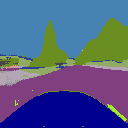

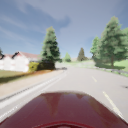

In [25]:
Image.fromarray(obs['camera'], 'RGB')